# MULTIMODAL PHISHING DETECTION NOTEBOOK


# Explainable and Efficient Multi-Modal Phishing Detection

## A Hybrid Approach Integrating Image Analysis and NLP-Based Text Classification

### Project Overview

This project implements a **multimodal phishing detection system** that combines visual (website screenshots) and textual (HTML metadata) features to classify websites as phishing or benign. The system employs a hybrid deep learning architecture integrating MobileNetV2 for visual feature extraction and XLM-RoBERTa for textual feature extraction, fused through an attention mechanism before binary classification.


# Dataset Setup

## Step 1: Add Dataset Links to Google Drive

**Important:** Before running this notebook, you need to add the dataset zip files to your Google Drive. You have two options:

### Option A: Add Shortcuts to Google Drive (Recommended for Large Files)

Since the datasets are very large (~7.3GB for phishing, ~56GB for benign), instead of downloading and re-uploading, you can add shortcuts to your Google Drive:

1. **Phishing Dataset:** [Open Link](https://drive.google.com/file/d/12ypEMPRQ43zGRqHGut0Esq2z5en0DH4g/view)
   - Right-click on the file in Google Drive
   - Select "Add shortcut to Drive"
   - Choose your folder (e.g., `multimodal_phishing_detection/`)
   - The shortcut will appear in your Drive and you can extract it directly

2. **Benign Dataset:** [Open Link](https://drive.google.com/file/d/1yORUeSrF5vGcgxYrsCoqXcpOUHt-iHq_/view)
   - Right-click on the file in Google Drive
   - Select "Add shortcut to Drive"
   - Choose your folder (e.g., `multimodal_phishing_detection/`)
   - The shortcut will appear in your Drive and you can extract it directly

**Benefits of using shortcuts:**
- No need to download and re-upload large files (saves bandwidth and time)
- Files remain in original location, saving your Drive storage
- Faster setup process
- You can extract directly from the shortcut location

### Option B: Download and Upload to Your Drive

If you prefer to have your own copies:

1. **Phishing Dataset:** [Download Link](https://drive.google.com/file/d/12ypEMPRQ43zGRqHGut0Esq2z5en0DH4g/view)
   - Download `phish_sample_30k.zip`
   - Upload to your Google Drive folder (e.g., `/content/drive/MyDrive/multimodal_phishing_detection/`)

2. **Benign Dataset:** [Download Link](https://drive.google.com/file/d/1yORUeSrF5vGcgxYrsCoqXcpOUHt-iHq_/view)
   - Download `benign_sample_30k.zip`
   - Upload to your Google Drive folder (e.g., `/content/drive/MyDrive/multimodal_phishing_detection/`)

**Note:**
- The datasets are large. Ensure you have sufficient storage space and download bandwidth.
- For testing purposes, you can use a subset of the data.
- **Dataset Source:** [Phishpedia Website](https://sites.google.com/view/phishpedia-site/home)

## Step 2: Create Data Directories and Extract Datasets

Run the following commands to create directories and extract the zip files.
**Note:** Update the paths below if your zip files are in a different Google Drive location.


In [ ]:
# Create data directories
!mkdir -p /content/data/phish_sample_30k
!mkdir -p /content/data/benign_sample_30k

## Step 3: Extract Datasets from Google Drive

**Important:** After adding shortcuts or uploading zip files to Google Drive, run the extraction commands below.
Update the paths if your files are in a different location.

**Note:** If you used shortcuts (Option A), the files will be accessible through the shortcut location in your Drive.
You can extract them directly from where you placed the shortcuts.

In [ ]:
# Extract datasets from Google Drive
# Update the paths below to match your Google Drive folder structure
# If you used shortcuts, use the shortcut location path
!unzip "/content/drive/MyDrive/multimodal_phishing_detection/benign_sample_30k.zip" -d /content/data/benign_sample_30k
!unzip "/content/drive/MyDrive/multimodal_phishing_detection/phish_sample_30k.zip" -d /content/data/phish_sample_30k


## Step 4: Verify Dataset Structure

After extraction, verify that the datasets are correctly extracted.
Each dataset should have the following structure:
```
phish_sample_30k/
├── Brand+Date-Time/
│   ├── shot.png          # Website screenshot
│   ├── html.txt          # HTML content
│   ├── ocr.txt           # OCR text (optional)
│   └── info.txt          # Metadata (URL, brand, etc.)

benign_sample_30k/
├── Brand+Date-Time/
│   ├── shot.png
│   ├── html.txt
│   ├── ocr.txt
│   └── info.txt

# 1. Imports & Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import Standard Libraries
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import json
from datetime import datetime
import warnings
import random
import re
import ast
import cv2
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score,
    matthews_corrcoef, precision_recall_fscore_support,
    roc_curve, precision_recall_curve, classification_report, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from transformers import (
    AutoTokenizer, XLMRobertaModel, XLMRobertaConfig,
    XLMRobertaTokenizer
)
import logging
import os
from typing import Dict, List, Tuple, Optional, Any, Callable
from dataclasses import dataclass

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("All libraries imported")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


All libraries imported
PyTorch: 2.8.0+cu126
CUDA available: False


# 2. Configuration Classes

In [5]:
# Configuration Classes
@dataclass
class ModelConfig:
    image_size: Tuple[int, int, int] = (224, 224, 3)
    visual_model_name: str = "mobilenetv2"
    visual_pretrained: bool = True
    visual_feature_dim: int = 1280
    visual_dropout: float = 0.2
    text_model_name: str = "xlm-roberta-base"
    max_sequence_length: int = 512
    text_feature_dim: int = 768
    text_dropout: float = 0.1
    fusion_method: str = "attention"
    fusion_hidden_dim: int = 512
    fusion_dropout: float = 0.3
    num_classes: int = 2
    max_model_size_mb: int = 150
    max_inference_time_ms: int = 300
    target_accuracy: float = 0.90
    target_f1_score: float = 0.85
    target_mcc: float = 0.80

@dataclass
class ExplainabilityConfig:
    gradcam_layer_name: str = "Conv_1"
    gradcam_target_iou: float = 0.6
    shap_method: str = "shap"
    shap_num_samples: int = 1000
    shap_fidelity_threshold: float = 0.8
    consistency_visual_iou_threshold: float = 0.6
    consistency_text_cosine_threshold: float = 0.8
    perturbation_strength: float = 0.1

@dataclass
class EvaluationConfig:
    fgsm_epsilon_values: Tuple[float, ...] = (0.01, 0.03, 0.05, 0.1)
    visual_perturbation_types: Tuple[str, ...] = ("noise", "blur", "contrast", "brightness")
    text_perturbation_types: Tuple[str, ...] = ("synonym", "insertion", "deletion", "swap")
    max_inference_time_ms: float = 300.0
    max_model_size_mb: float = 150.0

# Global config instances
model_config = ModelConfig()
explainability_config = ExplainabilityConfig()
evaluation_config = EvaluationConfig()

print("Configuration classes initialized")

Configuration classes initialized


# 3. Dataset Classes

 ## 1. Dataset Loading - Phishpedia Dataset

In [6]:
# Phishpedia Dataset Class
class PhishpediaDataset(Dataset):
    """Dataset class for Phishpedia (60k samples: 30k phishing + 30k benign)."""

    def __init__(self, phishing_dir="phish_sample_30k", benign_dir="benign_sample_30k",
                 split='train', max_samples=None, image_size=(224, 224), use_ocr=True, use_info=True):
        self.phishing_dir = Path(phishing_dir)
        self.benign_dir = Path(benign_dir)
        self.split = split
        self.image_size = image_size
        self.use_ocr = use_ocr
        self.use_info = use_info

        self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.samples = self._load_samples(max_samples)
        print(f"Loaded {len(self.samples)} {split} samples")
        print(f"  Phishing: {sum(1 for s in self.samples if s['label'] == 1)}")
        print(f"  Benign: {sum(1 for s in self.samples if s['label'] == 0)}")

    def _load_samples(self, max_samples):
        phishing_samples, benign_samples = [], []

        if self.phishing_dir.exists():
            for sample_dir in self.phishing_dir.iterdir():
                if sample_dir.is_dir():
                    sample = self._process_sample(sample_dir, label=1)
                    if sample:
                        phishing_samples.append(sample)

        if self.benign_dir.exists():
            for sample_dir in self.benign_dir.iterdir():
                if sample_dir.is_dir():
                    sample = self._process_sample(sample_dir, label=0)
                    if sample:
                        benign_samples.append(sample)

        if max_samples:
            samples_per_class = max_samples // 2
            phishing_samples = phishing_samples[:samples_per_class]
            benign_samples = benign_samples[:samples_per_class]
            samples = phishing_samples + benign_samples
            random.seed(42)
            random.shuffle(samples)
        else:
            samples = phishing_samples + benign_samples

        return samples

    def _process_sample(self, sample_dir, label):
        try:
            sample = {'label': label, 'sample_id': sample_dir.name, 'sample_dir': sample_dir}

            screenshot_path = sample_dir / "shot.png"
            if screenshot_path.exists():
                sample['screenshot_path'] = screenshot_path
            else:
                return None

            html_path = sample_dir / "html.txt"
            if html_path.exists():
                with open(html_path, 'r', encoding='utf-8', errors='ignore') as f:
                    sample['html_content'] = f.read()
            else:
                sample['html_content'] = ""

            if self.use_ocr:
                ocr_path = sample_dir / "ocr.txt"
                if ocr_path.exists():
                    with open(ocr_path, 'r', encoding='utf-8', errors='ignore') as f:
                        sample['ocr_content'] = f.read()
                else:
                    sample['ocr_content'] = ""

            if self.use_info:
                info_path = sample_dir / "info.txt"
                if info_path.exists():
                    try:
                        with open(info_path, 'r', encoding='utf-8') as f:
                            info_str = f.read()
                            try:
                                sample['metadata'] = ast.literal_eval(info_str)
                            except:
                                try:
                                    sample['metadata'] = json.loads(info_str)
                                except:
                                    sample['metadata'] = {}
                    except:
                        sample['metadata'] = {}
                else:
                    sample['metadata'] = {}

                if sample['metadata']:
                    sample['url'] = sample['metadata'].get('url', '')
                    sample['brand'] = sample['metadata'].get('brand', '')
                else:
                    sample['url'] = ''
                    sample['brand'] = ''
            else:
                sample['metadata'] = {}
                sample['url'] = ''
                sample['brand'] = ''

            return sample
        except Exception as e:
            print(f"Error processing {sample_dir}: {e}")
            return None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        try:
            image = Image.open(sample['screenshot_path']).convert('RGB')
            image = self.image_transform(image)
        except:
            image = torch.zeros(3, *self.image_size)

        text_parts = []
        if sample.get('html_content'):
            html_text = re.sub(r'<[^>]+>', ' ', sample['html_content'])
            text_parts.append(html_text[:2000])

        if self.use_ocr and sample.get('ocr_content'):
            text_parts.append(sample['ocr_content'][:500])

        if sample.get('url'):
            text_parts.append(sample['url'])

        text_content = ' '.join(text_parts)

        if text_content:
            text_tokens = self.tokenizer(text_content, max_length=512, padding='max_length',
                                        truncation=True, return_tensors='pt')
            text_input_ids = text_tokens['input_ids'].squeeze(0)
            text_attention_mask = text_tokens['attention_mask'].squeeze(0)
        else:
            text_input_ids = torch.zeros(512, dtype=torch.long)
            text_attention_mask = torch.zeros(512, dtype=torch.long)

        return {
            'image': image,
            'text_input_ids': text_input_ids,
            'text_attention_mask': text_attention_mask,
            'label': torch.tensor(sample['label'], dtype=torch.long),
            'sample_id': sample['sample_id'],
            'url': sample.get('url', ''),
            'brand': sample.get('brand', '')
        }

print("PhishpediaDataset class defined")

PhishpediaDataset class defined


In [7]:
# Dataset Analysis Function
def analyze_phishpedia_dataset(phishing_dir="phish_sample_30k", benign_dir="benign_sample_30k"):
    """Analyze Phishpedia dataset structure."""
    print("=== PHISHPEDIA DATASET ANALYSIS ===\n")

    phishing_path = Path(phishing_dir)
    benign_path = Path(benign_dir)

    phishing_count = len([d for d in phishing_path.iterdir() if d.is_dir()]) if phishing_path.exists() else 0
    benign_count = len([d for d in benign_path.iterdir() if d.is_dir()]) if benign_path.exists() else 0
    total_count = phishing_count + benign_count

    print(f"Total samples: {total_count:,}")
    print(f"  Phishing: {phishing_count:,}")
    print(f"  Benign: {benign_count:,}")

    if total_count > 0:
        balance_ratio = max(phishing_count, benign_count) / min(phishing_count, benign_count) if min(phishing_count, benign_count) > 0 else float('inf')
        print(f"  Balance ratio: {balance_ratio:.2f}")
        if balance_ratio <= 1.05:
            print("  Perfectly balanced")

    return {
        'total_samples': total_count,
        'phishing_samples': phishing_count,
        'benign_samples': benign_count,
        'balance_ratio': balance_ratio if total_count > 0 else 0
    }

In [8]:
# Cell 5: Create Data Loaders Function
def create_phishpedia_loaders(phishing_dir="phish_sample_30k", benign_dir="benign_sample_30k",
                             batch_size=16, train_split=0.8, val_split=0.1, test_split=0.1,
                             max_samples=None, image_size=(224, 224), use_ocr=True, use_info=True,
                             num_workers=None, pin_memory=None):
    """Create train/val/test data loaders with GPU optimization."""
    # Auto-detect GPU settings if not provided
    if num_workers is None:
        num_workers = 4 if torch.cuda.is_available() else 2
    if pin_memory is None:
        pin_memory = torch.cuda.is_available()

    full_dataset = PhishpediaDataset(
        phishing_dir=phishing_dir, benign_dir=benign_dir, split='all',
        max_samples=max_samples, image_size=image_size, use_ocr=use_ocr, use_info=use_info
    )

    total_size = len(full_dataset)
    train_size = int(total_size * train_split)
    val_size = int(total_size * val_split)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Optimized data loaders for GPU
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True if num_workers > 0 else False,
        prefetch_factor=2 if num_workers > 0 else None
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True if num_workers > 0 else False,
        prefetch_factor=2 if num_workers > 0 else None
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True if num_workers > 0 else False,
        prefetch_factor=2 if num_workers > 0 else None
    )

    print(f"\nData splits:")
    print(f"  Train: {train_size} ({train_split*100:.1f}%)")
    print(f"  Val: {val_size} ({val_split*100:.1f}%)")
    print(f"  Test: {test_size} ({test_split*100:.1f}%)")
    print(f"  DataLoader: num_workers={num_workers}, pin_memory={pin_memory}")

    return train_loader, val_loader, test_loader

# 4. Model Classes

## 2. Model Architecture - Hybrid Multimodal Model

In [9]:
# Visual Branch Class
class VisualBranch(nn.Module):
    """Visual feature extraction using MobileNetV2."""

    def __init__(self, backbone="mobilenet_v2", pretrained=True, feature_dim=512, dropout_rate=0.3, freeze_backbone=False):
        super().__init__()
        self.backbone_name = backbone
        self.feature_dim = feature_dim

        if backbone == "mobilenet_v2":
            model = models.mobilenet_v2(pretrained=pretrained)
            model.classifier = nn.Identity()
            self.backbone = model
            self.backbone_dim = 1280
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        self.feature_adaptation = nn.Sequential(
            nn.Linear(self.backbone_dim, feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(feature_dim)
        )

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, images):
        backbone_features = self.backbone(images)
        if backbone_features.dim() > 2:
            backbone_features = torch.mean(backbone_features, dim=[2, 3])
        return self.feature_adaptation(backbone_features)

In [10]:
# Text Branch Class
class TextBranch(nn.Module):
    """Text feature extraction using XLM-RoBERTa."""

    def __init__(self, model_name="xlm-roberta-base", feature_dim=512, dropout_rate=0.3, freeze_backbone=False, use_pooler=True, max_length=512):
        super().__init__()
        self.model_name = model_name
        self.feature_dim = feature_dim
        self.use_pooler = use_pooler
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.backbone = XLMRobertaModel.from_pretrained(model_name)
        self.backbone_dim = self.backbone.config.hidden_size

        self.feature_adaptation = nn.Sequential(
            nn.Linear(self.backbone_dim, feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(feature_dim)
        )

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        if self.use_pooler and hasattr(outputs, 'pooler_output'):
            text_features = outputs.pooler_output
        else:
            attention_mask_expanded = attention_mask.unsqueeze(-1).float()
            masked_hidden = outputs.last_hidden_state * attention_mask_expanded
            sum_hidden = torch.sum(masked_hidden, dim=1)
            count_mask = torch.clamp(torch.sum(attention_mask_expanded, dim=1), min=1e-9)
            text_features = sum_hidden / count_mask

        return self.feature_adaptation(text_features)

In [11]:
# Fusion Layer Class
class AttentionFusion(nn.Module):
    """Attention-based fusion for visual and text features."""

    def __init__(self, visual_dim=512, text_dim=512, fusion_dim=512, num_heads=8, dropout_rate=0.1):
        super().__init__()
        self.visual_query = nn.Linear(visual_dim, fusion_dim)
        self.text_key = nn.Linear(text_dim, fusion_dim)
        self.text_value = nn.Linear(text_dim, fusion_dim)

        self.attention = nn.MultiheadAttention(embed_dim=fusion_dim, num_heads=num_heads, dropout=dropout_rate, batch_first=True)
        self.norm1 = nn.LayerNorm(fusion_dim)
        self.norm2 = nn.LayerNorm(fusion_dim)

        self.ffn = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.Dropout(dropout_rate)
        )
        self.output_projection = nn.Linear(fusion_dim, fusion_dim)

    def forward(self, visual_features, text_features):
        query = self.visual_query(visual_features).unsqueeze(1)
        key = self.text_key(text_features).unsqueeze(1)
        value = self.text_value(text_features).unsqueeze(1)

        attended_features, _ = self.attention(query, key, value)
        attended_features = attended_features.squeeze(1)

        fused_features = self.norm1(attended_features + visual_features)
        ffn_output = self.ffn(fused_features)
        fused_features = self.norm2(ffn_output + fused_features)

        return self.output_projection(fused_features)


In [12]:
# Hybrid Model Class
class HybridPhishingDetector(nn.Module):
    """Hybrid multimodal phishing detection model."""

    def __init__(self, visual_backbone="mobilenet_v2", visual_pretrained=True, visual_feature_dim=512,
                 visual_lightweight=False, text_model_name="xlm-roberta-base", text_feature_dim=512,
                 text_lightweight=False, fusion_type="attention", num_classes=2, device="cpu"):
        super().__init__()

        self.device = device
        self.num_classes = num_classes

        self.visual_branch = VisualBranch(
            backbone=visual_backbone, pretrained=visual_pretrained,
            feature_dim=visual_feature_dim, dropout_rate=0.3, freeze_backbone=False
        )

        self.text_branch = TextBranch(
            model_name=text_model_name, feature_dim=text_feature_dim,
            dropout_rate=0.3, freeze_backbone=False, use_pooler=True, max_length=512
        )

        self.fusion_layer = AttentionFusion(
            visual_dim=visual_feature_dim, text_dim=text_feature_dim,
            fusion_dim=512, num_heads=8, dropout_rate=0.1
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        self.to(device)

    def forward(self, images, input_ids, attention_mask):
        images = images.to(self.device)
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)

        visual_features = self.visual_branch(images)
        text_features = self.text_branch(input_ids, attention_mask)
        fused_features = self.fusion_layer(visual_features, text_features)
        logits = self.classifier(fused_features)

        return logits

print("Model classes defined")

Model classes defined


 # 5. Training Classes

In [13]:
# Focal Loss Class
class FocalLoss(nn.Module):
    """Focal Loss for class imbalance."""

    def __init__(self, alpha=0.25, gamma=4.0, class_weights=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        weight = self.class_weights.to(inputs.device) if self.class_weights is not None else None
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=weight)
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        if self.alpha is not None:
            alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
            focal_weight = alpha_t * focal_weight
        return (focal_weight * ce_loss).mean()

In [14]:
# Model Trainer Class (Simplified for notebook)
class ModelTrainer:
    """Training pipeline with comprehensive metrics and GPU optimization."""

    def __init__(self, model, train_loader, val_loader, device="cpu", learning_rate=1e-4,
                 loss_type="focal", class_weights=None, focal_alpha=0.25, focal_gamma=4.0, use_amp=True):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.use_amp = use_amp and torch.cuda.is_available()  # Only use AMP on GPU

        if self.use_amp:
            self.scaler = torch.cuda.amp.GradScaler()
            print("Mixed Precision Training (AMP) enabled for faster training")

        if loss_type == "focal":
            self.loss_fn = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, class_weights=class_weights)
        else:
            weight = class_weights.to(device) if class_weights is not None else None
            self.loss_fn = nn.CrossEntropyLoss(weight=weight)

        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', patience=5, factor=0.5, min_lr=1e-7
        )

        self.best_val_f1 = 0.0
        self.history = {'train_losses': [], 'val_losses': [], 'val_accuracies': []}

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0
        all_preds, all_targets = [], []

        # Use autocast for mixed precision on GPU
        # Note: We need autocast context but not no_grad here (training needs gradients)
        autocast_context = torch.cuda.amp.autocast() if self.use_amp else nullcontext()

        for batch in tqdm(self.train_loader, desc="Training", leave=False):
            images = batch['images'].to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            labels = batch['labels'].to(self.device, non_blocking=True)

            self.optimizer.zero_grad()

            if self.use_amp:
                with autocast_context:
                    logits = self.model(images, input_ids, attention_mask)
                    loss = self.loss_fn(logits, labels)

                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                loss_value = loss.item()
            else:
                logits = self.model(images, input_ids, attention_mask)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                loss_value = loss.item()

            total_loss += loss_value
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        return {
            'loss': total_loss / len(self.train_loader),
            'accuracy': accuracy_score(all_targets, all_preds)
        }

    def validate_epoch(self):
        self.model.eval()
        total_loss = 0.0
        all_preds, all_targets = [], []

        autocast_context = torch.cuda.amp.autocast() if self.use_amp else torch.no_grad()

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation", leave=False):
                images = batch['images'].to(self.device, non_blocking=True)
                input_ids = batch['input_ids'].to(self.device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
                labels = batch['labels'].to(self.device, non_blocking=True)

                if self.use_amp:
                    with autocast_context:
                        logits = self.model(images, input_ids, attention_mask)
                        loss = self.loss_fn(logits, labels)
                else:
                    logits = self.model(images, input_ids, attention_mask)
                    loss = self.loss_fn(logits, labels)

                total_loss += loss.item()
                all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, zero_division=0)

        return {'loss': total_loss / len(self.val_loader), 'accuracy': accuracy, 'f1': f1}

    def train(self, num_epochs=5):
        for epoch in range(num_epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate_epoch()

            self.scheduler.step(val_metrics['f1'])

            self.history['train_losses'].append(train_metrics['loss'])
            self.history['val_losses'].append(val_metrics['loss'])
            self.history['val_accuracies'].append(val_metrics['accuracy'])

            if val_metrics['f1'] > self.best_val_f1:
                self.best_val_f1 = val_metrics['f1']

            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"  Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['accuracy']:.4f}")
            print(f"  Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, Val F1: {val_metrics['f1']:.4f}")

        return self.history

print("Training classes defined")

Training classes defined


# 6. Evaluation Classes

In [15]:
# Comprehensive Evaluator Class
class ComprehensiveEvaluator:
    """Comprehensive evaluation with all metrics."""

    def __init__(self, class_names=['Legitimate', 'Phishing']):
        self.class_names = class_names

    def evaluate_model(self, y_true, y_pred, y_prob=None):
        y_true = np.array(y_true) if not isinstance(y_true, np.ndarray) else y_true
        y_pred = np.array(y_pred) if not isinstance(y_pred, np.ndarray) else y_pred

        results = {'accuracy': accuracy_score(y_true, y_pred)}

        unique_labels = sorted(set(np.concatenate([y_true, y_pred])))
        if len(unique_labels) < 2:
            if 0 not in unique_labels:
                precision = np.array([0.0, 1.0])
                recall = np.array([0.0, 1.0])
                f1 = np.array([0.0, 1.0])
            else:
                precision = np.array([1.0, 0.0])
                recall = np.array([1.0, 0.0])
                f1 = np.array([1.0, 0.0])
        else:
            precision, recall, f1, support = precision_recall_fscore_support(
                y_true, y_pred, average=None, labels=[0, 1], zero_division=0
            )

        results['precision_per_class'] = {'legitimate': float(precision[0]), 'phishing': float(precision[1])}
        results['recall_per_class'] = {'legitimate': float(recall[0]), 'phishing': float(recall[1])}
        results['f1_per_class'] = {'legitimate': float(f1[0]), 'phishing': float(f1[1])}
        results['macro_f1'] = float(np.mean(f1))
        results['weighted_f1'] = float(np.average(f1, weights=support)) if support.sum() > 0 else 0.0

        if y_prob is not None:
            y_prob = np.array(y_prob) if not isinstance(y_prob, np.ndarray) else y_prob
            if len(np.unique(y_true)) >= 2:
                try:
                    results['roc_auc'] = roc_auc_score(y_true, y_prob)
                except:
                    results['roc_auc'] = None
            else:
                results['roc_auc'] = None

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        results['confusion_matrix'] = cm

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn, fp, fn, tp = 0, 0, 0, 0

        results['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        results['true_positive_rate'] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        results['mcc'] = (tp * tn - fp * fn) / denominator if denominator > 0 else 0.0

        results['f1_weighted'] = results['weighted_f1']
        results['f1_macro'] = results['macro_f1']

        return results

    def generate_detailed_report(self, results):
        roc_auc_value = results.get('roc_auc')
        roc_auc_str = f"{roc_auc_value:.4f}" if roc_auc_value is not None else "N/A"

        report = f"""
COMPREHENSIVE MODEL EVALUATION REPORT
=====================================

OVERALL PERFORMANCE:
- Accuracy: {results['accuracy']:.4f}
- Macro F1: {results['macro_f1']:.4f}
- Weighted F1: {results['weighted_f1']:.4f}
- ROC-AUC: {roc_auc_str}
- MCC: {results['mcc']:.4f}

PER-CLASS PERFORMANCE:
Legitimate Class:
- Precision: {results['precision_per_class']['legitimate']:.4f}
- Recall: {results['recall_per_class']['legitimate']:.4f}
- F1-Score: {results['f1_per_class']['legitimate']:.4f}

Phishing Class:
- Precision: {results['precision_per_class']['phishing']:.4f}
- Recall: {results['recall_per_class']['phishing']:.4f}
- F1-Score: {results['f1_per_class']['phishing']:.4f}

CRITICAL PHISHING DETECTION METRICS:
- False Positive Rate: {results['false_positive_rate']:.4f}
- True Positive Rate (Sensitivity): {results['true_positive_rate']:.4f}
- Specificity: {results['specificity']:.4f}

CONFUSION MATRIX:
{results['confusion_matrix']}
"""
        print(report)

print("Evaluation classes defined")

Evaluation classes defined


# 7. Explainability Classes - Grad-CAM & SHAP

In [16]:
# Grad-CAM Explainer Class
class GradCAMExplainer:
    """Grad-CAM for visual explanations."""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.forward_hook = target_layer.register_forward_hook(self._save_activation)
        self.backward_hook = target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self, input_tensor, input_ids=None, attention_mask=None, class_idx=None, normalize=True):
        """
        Generate Grad-CAM heatmap for multimodal model.

        Args:
            input_tensor: Image tensor
            input_ids: Text input IDs (required for multimodal models)
            attention_mask: Text attention mask (required for multimodal models)
            class_idx: Target class index (None = use predicted class)
            normalize: Whether to normalize heatmap values
        """
        self.model.eval()
        input_tensor.requires_grad_(True)

        # For multimodal models, we need text inputs
        if input_ids is not None and attention_mask is not None:
            output = self.model(input_tensor, input_ids, attention_mask)
        else:
            # Fallback for image-only models
            output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward(retain_graph=True)

        # Check if gradients and activations were captured
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations not captured. Check target layer selection.")

        gradients = self.gradients[0]
        activations = self.activations[0]

        # Handle different tensor shapes
        if len(gradients.shape) == 4:  # [batch, channels, height, width]
            weights = torch.mean(gradients, dim=(2, 3))  # Average over spatial dimensions
        elif len(gradients.shape) == 3:  # [batch, channels, features]
            weights = torch.mean(gradients, dim=2)
        else:
            weights = gradients

        # Ensure activations have compatible shape
        if len(activations.shape) == 4:
            heatmap = torch.zeros(activations.shape[2:])  # [height, width]
            for i, weight in enumerate(weights[0]):
                if i < activations.shape[1]:
                    heatmap += weight * activations[0, i]
        else:
            # Fallback: create heatmap from activations directly
            heatmap = torch.mean(activations[0], dim=0)
            if len(heatmap.shape) > 2:
                heatmap = torch.mean(heatmap, dim=0)

        heatmap = F.relu(heatmap)
        heatmap = heatmap.cpu().numpy()

        if normalize:
            if heatmap.max() > heatmap.min():
                heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
            else:
                heatmap = np.zeros_like(heatmap)

        return heatmap

    def cleanup(self):
        if hasattr(self, 'forward_hook'):
            self.forward_hook.remove()
        if hasattr(self, 'backward_hook'):
            self.backward_hook.remove()

In [17]:
# Install SHAP and LIME
!pip install -q shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [18]:
# SHAP Text Explainer
try:
    import shap
    from lime.lime_text import LimeTextExplainer

    class SHAPExplainer:
        """Gradient-based SHAP explainer for text inputs."""

        def __init__(self, model, tokenizer, max_length=512, device=None):
            self.model = model
            self.tokenizer = tokenizer
            self.max_length = max_length
            self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
            self.model.eval()  # Set model to eval mode

        def _get_model_prediction(self, input_ids, attention_mask):
            """Get model prediction for given input_ids and attention_mask."""
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)

            # Use full multimodal model with dummy images (zeros)
            batch_size = input_ids.shape[0]
            dummy_images = torch.zeros(batch_size, 3, 224, 224).to(self.device)

            with torch.no_grad():
                outputs = self.model(dummy_images, input_ids, attention_mask)
                probs = torch.softmax(outputs, dim=1)

            return probs[:, 1].cpu().numpy()  # Return probability of phishing class

        def explain_text(self, text, num_samples=50):
            """Generate SHAP-like explanations using gradient-based approach."""
            try:
                # Tokenize the text
                tokens = self.tokenizer.tokenize(text)
                if len(tokens) == 0:
                    return {'text': text, 'attributions': [], 'tokens': []}

                encoded = self.tokenizer(
                    text,
                    max_length=self.max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )

                input_ids = encoded['input_ids'].to(self.device)
                attention_mask = encoded['attention_mask'].to(self.device)

                # Get baseline prediction (all padding)
                pad_token_id = self.tokenizer.pad_token_id if self.tokenizer.pad_token_id is not None else 0
                baseline_ids = torch.full_like(input_ids, pad_token_id)
                baseline_mask = torch.zeros_like(attention_mask)
                baseline_prob = self._get_model_prediction(baseline_ids, baseline_mask)[0]

                # Get original prediction
                original_prob = self._get_model_prediction(input_ids, attention_mask)[0]

                # Use gradient-based approach (more reliable than masking)
                # Get embeddings and compute gradients
                embeddings = self.model.text_branch.backbone.embeddings(input_ids)
                embeddings.requires_grad_(True)

                # Forward pass
                batch_size = input_ids.shape[0]
                dummy_images = torch.zeros(batch_size, 3, 224, 224).to(self.device)

                # Get text features
                text_outputs = self.model.text_branch.backbone(
                    inputs_embeds=embeddings,
                    attention_mask=attention_mask
                )

                if hasattr(text_outputs, 'pooler_output') and text_outputs.pooler_output is not None:
                    text_features = text_outputs.pooler_output
                else:
                    attention_mask_expanded = attention_mask.unsqueeze(-1).float()
                    masked_hidden = text_outputs.last_hidden_state * attention_mask_expanded
                    sum_hidden = torch.sum(masked_hidden, dim=1)
                    count_mask = torch.clamp(torch.sum(attention_mask_expanded, dim=1), min=1e-9)
                    text_features = sum_hidden / count_mask

                visual_features = self.model.visual_branch(dummy_images)
                fused_features = self.model.fusion_layer(visual_features.unsqueeze(1), text_features.unsqueeze(1))
                fused_features = fused_features.squeeze(1)
                outputs = self.model.classifier(fused_features)
                probs = torch.softmax(outputs, dim=1)

                # Compute gradients
                self.model.zero_grad()
                target_prob = probs[0, 1]  # Phishing probability
                target_prob.backward()

                # Get gradient magnitudes per token
                if embeddings.grad is not None:
                    # L2 norm of gradient per token position
                    grad_norms = torch.norm(embeddings.grad[0], dim=1).cpu().numpy()
                else:
                    grad_norms = np.zeros(attention_mask.shape[1])

                # Combine gradient-based with token masking for better accuracy
                attributions = []
                actual_token_count = min(len(tokens), int(attention_mask.sum().item()))

                for token_idx in range(actual_token_count):
                    # Skip if this is padding
                    if attention_mask[0, token_idx].item() == 0:
                        attributions.append(0.0)
                        continue

                    # Create input with this specific token masked
                    test_ids = input_ids.clone()
                    test_ids[0, token_idx] = pad_token_id

                    test_mask = attention_mask.clone()
                    test_mask[0, token_idx] = 0

                    # Get prediction without this token
                    try:
                        test_prob = self._get_model_prediction(test_ids, test_mask)[0]

                        # Attribution = how much removing this token changes the prediction
                        attribution = original_prob - test_prob

                        # Weight by gradient magnitude for better signal
                        if token_idx < len(grad_norms):
                            grad_weight = float(grad_norms[token_idx])
                            # Combine: 70% masking impact, 30% gradient magnitude
                            attribution = 0.7 * attribution + 0.3 * grad_weight * np.sign(attribution) if attribution != 0 else grad_weight * 0.1

                        attributions.append(float(attribution))
                    except Exception as e:
                        # Fallback: use gradient only
                        if token_idx < len(grad_norms):
                            attributions.append(float(grad_norms[token_idx]) * 0.1)  # Scale down
                        else:
                            attributions.append(0.0)

                # Ensure attributions match tokens length
                if len(attributions) < len(tokens):
                    attributions.extend([0.0] * (len(tokens) - len(attributions)))
                elif len(attributions) > len(tokens):
                    attributions = attributions[:len(tokens)]

                # Only normalize if we have meaningful values (don't normalize all zeros)
                if len(attributions) > 0:
                    max_attr = max(map(abs, attributions))
                    min_attr = min(attributions)

                    # If we have non-zero attributions, normalize them
                    if max_attr > 1e-6:  # Threshold to avoid normalizing noise
                        # Normalize to [-1, 1] range
                        if abs(min_attr) > max_attr:
                            norm_factor = abs(min_attr)
                        else:
                            norm_factor = max_attr
                        attributions = [a / norm_factor for a in attributions]
                    # If all zeros or very small, at least scale them up slightly for visualization
                    elif max_attr > 0:
                        attributions = [a * 1000 for a in attributions]  # Scale up tiny values

                return {
                    'text': text,
                    'attributions': attributions,
                    'tokens': tokens
                }

            except Exception as e:
                # Fallback: use gradient-based approach with embeddings
                try:
                    tokens = self.tokenizer.tokenize(text)
                    if len(tokens) == 0:
                        return {'text': text, 'attributions': [], 'tokens': []}

                    encoded = self.tokenizer(
                        text,
                        max_length=self.max_length,
                        padding="max_length",
                        truncation=True,
                        return_tensors="pt"
                    )

                    input_ids = encoded['input_ids'].to(self.device)
                    attention_mask = encoded['attention_mask'].to(self.device)

                    # Use embedding layer gradients
                    embeddings = self.model.text_branch.backbone.embeddings(input_ids)
                    embeddings.requires_grad_(True)

                    batch_size = input_ids.shape[0]
                    dummy_images = torch.zeros(batch_size, 3, 224, 224).to(self.device)

                    # Forward pass with embeddings
                    text_outputs = self.model.text_branch.backbone(
                        inputs_embeds=embeddings,
                        attention_mask=attention_mask
                    )

                    if hasattr(text_outputs, 'pooler_output') and text_outputs.pooler_output is not None:
                        text_features = text_outputs.pooler_output
                    else:
                        attention_mask_expanded = attention_mask.unsqueeze(-1).float()
                        masked_hidden = text_outputs.last_hidden_state * attention_mask_expanded
                        sum_hidden = torch.sum(masked_hidden, dim=1)
                        count_mask = torch.clamp(torch.sum(attention_mask_expanded, dim=1), min=1e-9)
                        text_features = sum_hidden / count_mask

                    visual_features = self.model.visual_branch(dummy_images)
                    fused_features = self.model.fusion_layer(visual_features.unsqueeze(1), text_features.unsqueeze(1))
                    fused_features = fused_features.squeeze(1)
                    outputs = self.model.classifier(fused_features)
                    probs = torch.softmax(outputs, dim=1)

                    self.model.zero_grad()
                    target_prob = probs[0, 1]
                    target_prob.backward()

                    if embeddings.grad is not None:
                        # Use L2 norm of gradients per token as attribution
                        grad_scores = torch.norm(embeddings.grad[0], dim=1).cpu().numpy()

                        # Normalize
                        max_grad = grad_scores.max()
                        if max_grad > 0:
                            grad_scores = grad_scores / max_grad
                        else:
                            grad_scores = np.zeros_like(grad_scores)

                        # Align with actual tokens (skip padding)
                        actual_token_count = min(len(tokens), int(attention_mask.sum().item()))
                        attributions = grad_scores[:actual_token_count].tolist()

                        # Pad or truncate to match token count
                        if len(attributions) < len(tokens):
                            attributions.extend([0.0] * (len(tokens) - len(attributions)))
                        elif len(attributions) > len(tokens):
                            attributions = attributions[:len(tokens)]
                    else:
                        attributions = [0.0] * len(tokens)

                    return {
                        'text': text,
                        'attributions': attributions,
                        'tokens': tokens
                    }
                except Exception as e2:
                    tokens = self.tokenizer.tokenize(text)
                    return {
                        'text': text,
                        'attributions': [0.0] * len(tokens),
                        'tokens': tokens
                    }

    class TextExplainerFactory:
        @staticmethod
        def create_explainer(method, model, tokenizer, **kwargs):
            if method.lower() == "shap":
                return SHAPExplainer(model, tokenizer, **kwargs)
            else:
                raise ValueError(f"Unsupported method: {method}")

    print("SHAP available")
except ImportError:
    print("SHAP/LIME not installed - text explainability limited")
    class SHAPExplainer:
        def __init__(self, *args, **kwargs):
            pass

    class TextExplainerFactory:
        @staticmethod
        def create_explainer(*args, **kwargs):
            return None

print("Explainability classes defined")

SHAP available
Explainability classes defined


# 8. Adversarial Testing

In [19]:
# Adversarial Tester Class
class AdversarialTester:
    """FGSM adversarial testing."""

    def __init__(self, model, device="cuda"):
        self.model = model.to(device)
        self.device = device

    def fgsm_attack(self, images, input_ids, attention_mask, labels, epsilon=0.03, target_modality="visual"):
        self.model.eval()

        if target_modality == "visual":
            images.requires_grad_(True)
            outputs = self.model(images, input_ids, attention_mask)
            loss = F.cross_entropy(outputs, labels)

            self.model.zero_grad()
            loss.backward()

            data_grad = images.grad.data
            sign_data_grad = data_grad.sign()
            adversarial_images = images + epsilon * sign_data_grad
            adversarial_images = torch.clamp(adversarial_images, 0, 1)

            return adversarial_images.detach(), images.detach()
        else:
            return input_ids, input_ids

print("Adversarial testing classes defined")

Adversarial testing classes defined


# 9. Pipeline Execution

In [20]:
# Cell 16: GPU Setup and Dataset Loading
print("GPU SETUP AND DATASET LOADING")

# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
    # Optimize GPU performance
    torch.backends.cudnn.benchmark = True  # Faster convolutions
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic for speed
    # Enable mixed precision training for faster processing
    use_amp = True  # Automatic Mixed Precision
    print(f"   Mixed Precision Training: Enabled")
else:
    print("  GPU not available, using CPU")
    use_amp = False

print(f"\nUsing device: {device}\n")

NUM_SAMPLES = 1000
# Increase batch size for GPU (15GB can handle larger batches)
if torch.cuda.is_available():
    BATCH_SIZE = 16
    NUM_WORKERS = 0
    PIN_MEMORY = True
else:
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    PIN_MEMORY = False

print(f"Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Num workers: {NUM_WORKERS}")
print(f"  Pin memory: {PIN_MEMORY}")

# Update this with path
PHISHING_DIR = "/content/data/phish_sample_30k"
BENIGN_DIR = "/content/data/benign_sample_30k"


dataset_stats = analyze_phishpedia_dataset(
    phishing_dir=PHISHING_DIR,
    benign_dir=BENIGN_DIR
)

train_loader, val_loader, test_loader = create_phishpedia_loaders(
    phishing_dir=PHISHING_DIR,
    benign_dir=BENIGN_DIR,
    batch_size=BATCH_SIZE,
    max_samples=NUM_SAMPLES,
    image_size=(224, 224),
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"\n Data loaders created:")
print(f"  Train: {len(train_loader.dataset):,}")
print(f"  Val: {len(val_loader.dataset):,}")
print(f"  Test: {len(test_loader.dataset):,}")

GPU SETUP AND DATASET LOADING
  GPU not available, using CPU

Using device: cpu

Configuration:
  Batch size: 16
  Num workers: 2
  Pin memory: False
=== PHISHPEDIA DATASET ANALYSIS ===

Total samples: 30,649
  Phishing: 0
  Benign: 30,649
  Balance ratio: inf


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loaded 500 all samples
  Phishing: 0
  Benign: 500

Data splits:
  Train: 400 (80.0%)
  Val: 50 (10.0%)
  Test: 50 (10.0%)
  DataLoader: num_workers=2, pin_memory=False

 Data loaders created:
  Train: 400
  Val: 50
  Test: 50



Sample batch:
  Images: torch.Size([16, 3, 224, 224])
  Text IDs: torch.Size([16, 512])
  Labels: torch.Size([16])


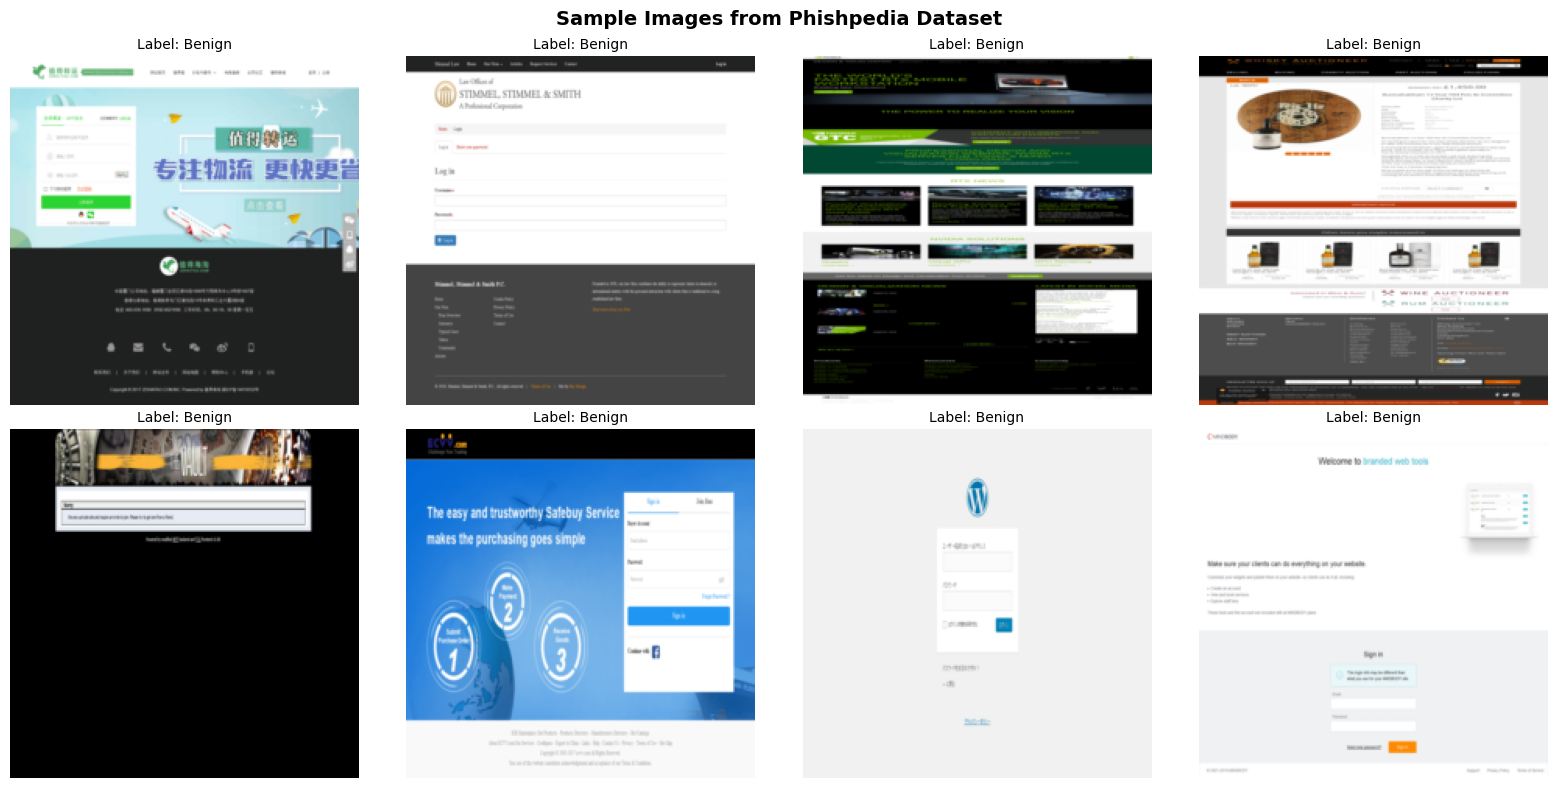

In [21]:
# Visualize Sample Data
sample_batch = next(iter(train_loader))

print(f"\nSample batch:")
print(f"  Images: {sample_batch['image'].shape}")
print(f"  Text IDs: {sample_batch['text_input_ids'].shape}")
print(f"  Labels: {sample_batch['label'].shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, sample_batch['image'].shape[0])):
    img = sample_batch['image'][i]
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_denorm = torch.clamp((img * std + mean), 0, 1)

    axes[i].imshow(img_denorm.permute(1, 2, 0).numpy())
    label = "Phishing" if sample_batch['label'][i].item() == 1 else "Benign"
    axes[i].set_title(f"Label: {label}", fontsize=10)
    axes[i].axis('off')

plt.suptitle("Sample Images from Phishpedia Dataset", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

CLASS DISTRIBUTION ANALYSIS

Class distribution:
  Benign: 399 (49.88%)
  Phishing: 401 (50.12%)


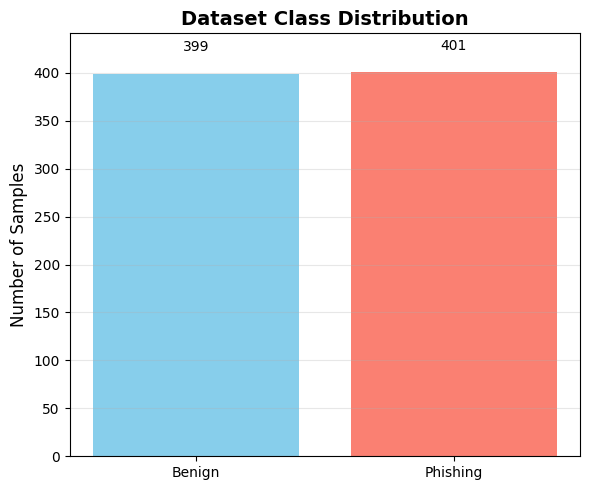

In [49]:
# Class Distribution Analysis and Visualization
print("CLASS DISTRIBUTION ANALYSIS")

# Calculate class distribution
class_counts = {0: 0, 1: 0}
# Use full dataset for accurate distribution if max_samples is used
if 'full_dataset' in locals():
    for sample in full_dataset:
        class_counts[int(sample['label'])] += 1
else: # Fallback to train loader if full_dataset not available (less accurate if max_samples is used)
     for batch in train_loader:
        for label in batch['label'].numpy():
            class_counts[int(label)] += 1


total_samples_dist = sum(class_counts.values())
if total_samples_dist > 0:
    benign_percentage = (class_counts.get(0, 0) / total_samples_dist) * 100
    phishing_percentage = (class_counts.get(1, 0) / total_samples_dist) * 100
else:
    benign_percentage = 0
    phishing_percentage = 0

print(f"\nClass distribution:")
print(f"  Benign: {class_counts.get(0, 0):,} ({benign_percentage:.2f}%)")
print(f"  Phishing: {class_counts.get(1, 0):,} ({phishing_percentage:.2f}%)")

# Visualize class distribution
if total_samples_dist > 0:
    labels = ['Benign', 'Phishing']
    counts = [class_counts.get(0, 0), class_counts.get(1, 0)]

    plt.figure(figsize=(6, 5))
    bars = plt.bar(labels, counts, color=['skyblue', 'salmon'])
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
    plt.ylim(0, max(counts) * 1.1) # Add a little space above the tallest bar
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., yval + 0.05*max(counts), f'{yval:,}', ha='center', va='bottom', fontsize=10)


    plt.tight_layout()
    plt.show()
else:
    print("  No samples to visualize class distribution.")

In [37]:
# Model Initialization
print("MODEL INITIALIZATION")
# Device should already be set from Cell 16, but ensure it's correct
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated(0) / (1024**3):.2f} GB")
    print(f"GPU Memory reserved: {torch.cuda.memory_reserved(0) / (1024**3):.2f} GB")
print()

model = HybridPhishingDetector(
    visual_backbone="mobilenet_v2",
    visual_pretrained=True,
    visual_feature_dim=512,
    text_model_name="xlm-roberta-base",
    text_feature_dim=512,
    fusion_type="attention",
    num_classes=2,
    device=str(device)
).to(device)

total_params = sum(p.numel() for p in model.parameters())
model_size_mb = total_params * 4 / (1024 * 1024)

print(f"Model:")
print(f"  Parameters: {total_params:,}")
print(f"  Size: {model_size_mb:.2f} MB")
print(f"  Initialized on {device}")

MODEL INITIALIZATION
Device: cuda
GPU Memory allocated: 0.00 GB
GPU Memory reserved: 0.00 GB

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 138MB/s]


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Model:
  Parameters: 284,637,058
  Size: 1085.80 MB
  Initialized on cuda


In [38]:
# Training Configuration
print("TRAINING CONFIGURATION")

class_weights = torch.tensor([
    1.0 / class_counts.get(0, 1),
    1.0 / class_counts.get(1, 1)
], dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * 2

print(f"Class weights: {class_weights.tolist()}")

# Adapt batch format
def adapt_batch(batch):
    return {
        'images': batch['image'],
        'input_ids': batch['text_input_ids'],
        'attention_mask': batch['text_attention_mask'],
        'labels': batch['label']
    }

class AdaptedLoader:
    def __init__(self, loader):
        self.original_loader = loader
        self.dataset = loader.dataset

    def __iter__(self):
        for batch in self.original_loader:
            yield adapt_batch(batch)

    def __len__(self):
        return len(self.original_loader)

train_loader_adapted = AdaptedLoader(train_loader)
val_loader_adapted = AdaptedLoader(val_loader)

trainer = ModelTrainer(
    model=model,
    train_loader=train_loader_adapted,
    val_loader=val_loader_adapted,
    device=str(device),
    learning_rate=1e-4,
    loss_type="focal",
    class_weights=class_weights,
    focal_alpha=0.25,
    focal_gamma=4.0,
    use_amp=use_amp
)

print("Trainer initialized")

TRAINING CONFIGURATION
Class weights: [1.0024999380111694, 0.9975000023841858]
Mixed Precision Training (AMP) enabled for faster training
Trainer initialized


In [39]:
# Model Training
print("MODEL TRAINING")

NUM_EPOCHS = 10

start_time = time.time()
train_history = trainer.train(num_epochs=NUM_EPOCHS)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time/60:.2f} minutes")
print(f"Final train loss: {train_history['train_losses'][-1]:.4f}")
print(f"Final val loss: {train_history['val_losses'][-1]:.4f}")

MODEL TRAINING



Epoch 1/10:
  Train Loss: 0.0159, Train Acc: 0.6362
  Val Loss: 0.0134, Val Acc: 0.7300, Val F1: 0.6087



Epoch 2/10:
  Train Loss: 0.0120, Train Acc: 0.7887
  Val Loss: 0.0086, Val Acc: 0.8200, Val F1: 0.7692



Epoch 3/10:
  Train Loss: 0.0095, Train Acc: 0.8500
  Val Loss: 0.0079, Val Acc: 0.8400, Val F1: 0.8095



Epoch 4/10:
  Train Loss: 0.0059, Train Acc: 0.9087
  Val Loss: 0.0075, Val Acc: 0.9000, Val F1: 0.8913



Epoch 5/10:
  Train Loss: 0.0056, Train Acc: 0.9437
  Val Loss: 0.0081, Val Acc: 0.9100, Val F1: 0.8989



Epoch 6/10:
  Train Loss: 0.0037, Train Acc: 0.9587
  Val Loss: 0.0104, Val Acc: 0.8700, Val F1: 0.8471



Epoch 7/10:
  Train Loss: 0.0032, Train Acc: 0.9663
  Val Loss: 0.0139, Val Acc: 0.8900, Val F1: 0.8706



Epoch 8/10:
  Train Loss: 0.0034, Train Acc: 0.9613
  Val Loss: 0.0166, Val Acc: 0.8200, Val F1: 0.7805



Epoch 9/10:
  Train Loss: 0.0021, Train Acc: 0.9762
  Val Loss: 0.0199, Val Acc: 0.8300, Val F1: 0.8132



Epoch 10/10:
  Train Loss: 0.0016, Train Acc: 0.9850
  Val Loss: 0.0148, Val Acc: 0.9000, Val F1: 0.8913

Training completed in 13.99 minutes
Final train loss: 0.0016
Final val loss: 0.0148


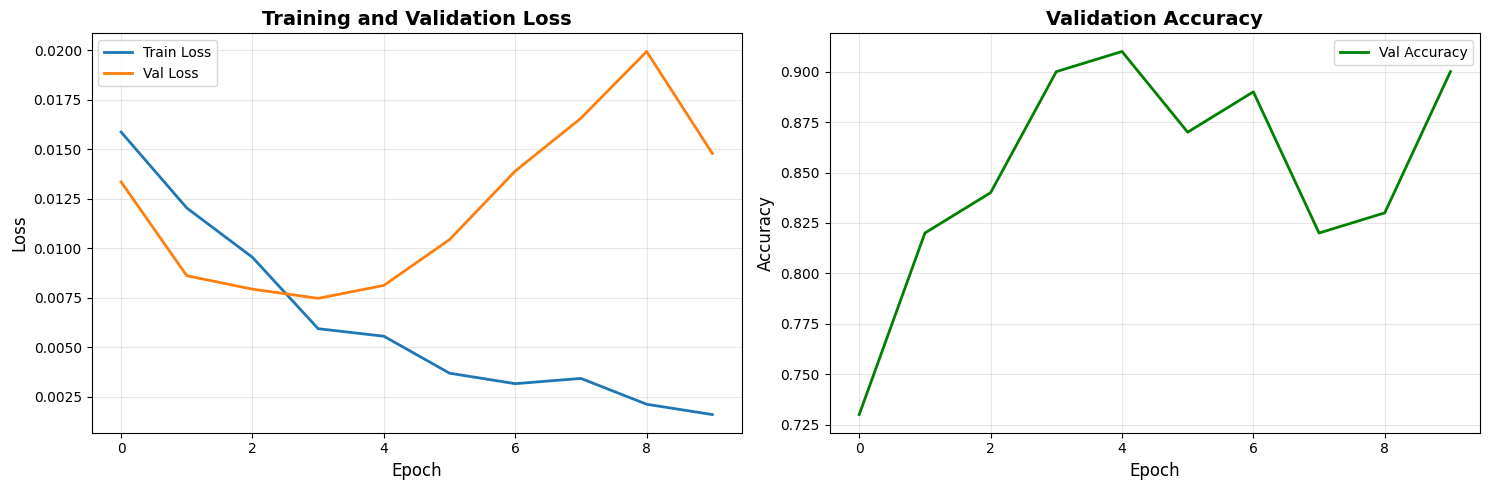

In [40]:
# Training Curves Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_history['train_losses'], label='Train Loss', linewidth=2)
axes[0].plot(train_history['val_losses'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

if train_history.get('val_accuracies'):
    axes[1].plot(train_history['val_accuracies'], label='Val Accuracy', linewidth=2, color='green')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
# Comprehensive Evaluation
print("COMPREHENSIVE EVALUATION")
evaluator = ComprehensiveEvaluator()

all_preds, all_labels, all_probs = [], [], []

model.eval()
print("Collecting predictions...")
# Use mixed precision for faster inference on GPU
use_amp_inference = torch.cuda.is_available() and use_amp
autocast_context = torch.cuda.amp.autocast() if use_amp_inference else nullcontext()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        images = batch['image'].to(device, non_blocking=True)
        text_input_ids = batch['text_input_ids'].to(device, non_blocking=True)
        text_attention_mask = batch['text_attention_mask'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)

        if use_amp_inference:
            with autocast_context:
                outputs = model(images, text_input_ids, text_attention_mask)
        else:
            outputs = model(images, text_input_ids, text_attention_mask)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

eval_results = evaluator.evaluate_model(all_labels, all_preds, all_probs)
evaluator.generate_detailed_report(eval_results)

COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


COMPREHENSIVE MODEL EVALUATION REPORT

OVERALL PERFORMANCE:
- Accuracy: 0.9400
- Macro F1: 0.9400
- Weighted F1: 0.9400
- ROC-AUC: 0.9848
- MCC: 0.8808

PER-CLASS PERFORMANCE:
Legitimate Class:
- Precision: 0.9216
- Recall: 0.9592
- F1-Score: 0.9400

Phishing Class:
- Precision: 0.9592
- Recall: 0.9216
- F1-Score: 0.9400

CRITICAL PHISHING DETECTION METRICS:
- False Positive Rate: 0.0408
- True Positive Rate (Sensitivity): 0.9216
- Specificity: 0.9592

CONFUSION MATRIX:
[[47  2]
 [ 4 47]]



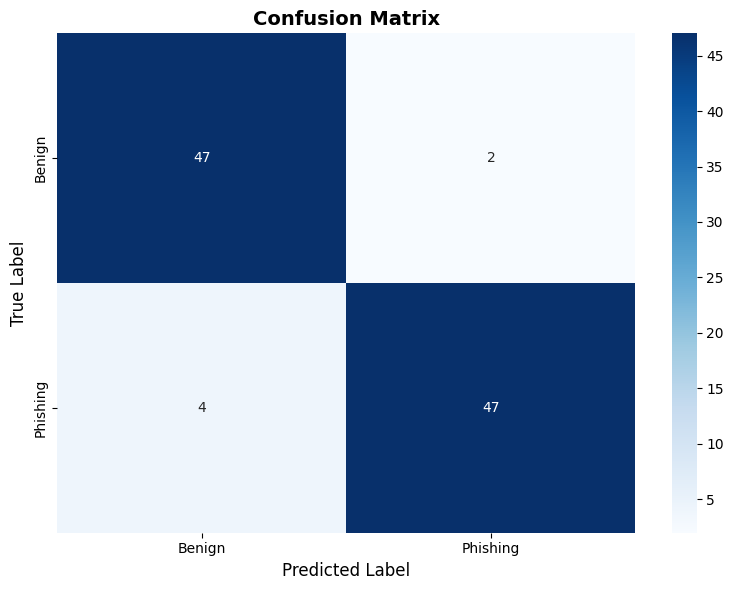


Confusion Matrix Details:
  TN: 47, FP: 2, FN: 4, TP: 47
  FPR: 0.0408, FNR: 0.0784


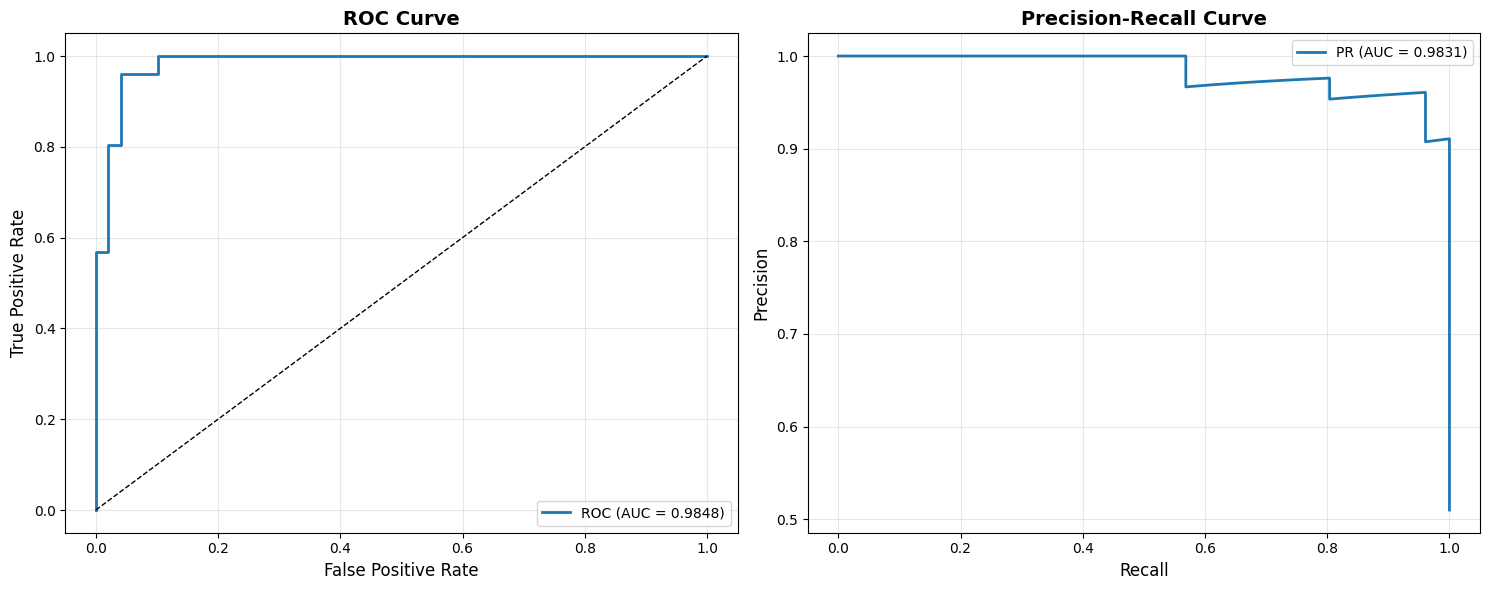


Area Under Curves:
  ROC-AUC: 0.9848
  PR-AUC: 0.9831


In [42]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Details:")
print(f"  TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"  FPR: {fp/(fp+tn):.4f}, FNR: {fn/(fn+tp):.4f}")

# Cell 24: ROC and PR Curves
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(recall, precision, linewidth=2, label=f'PR (AUC = {pr_auc:.4f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nArea Under Curves:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}")


EXPLAINABILITY - GRAD-CAM
 Grad-CAM explainer initialized


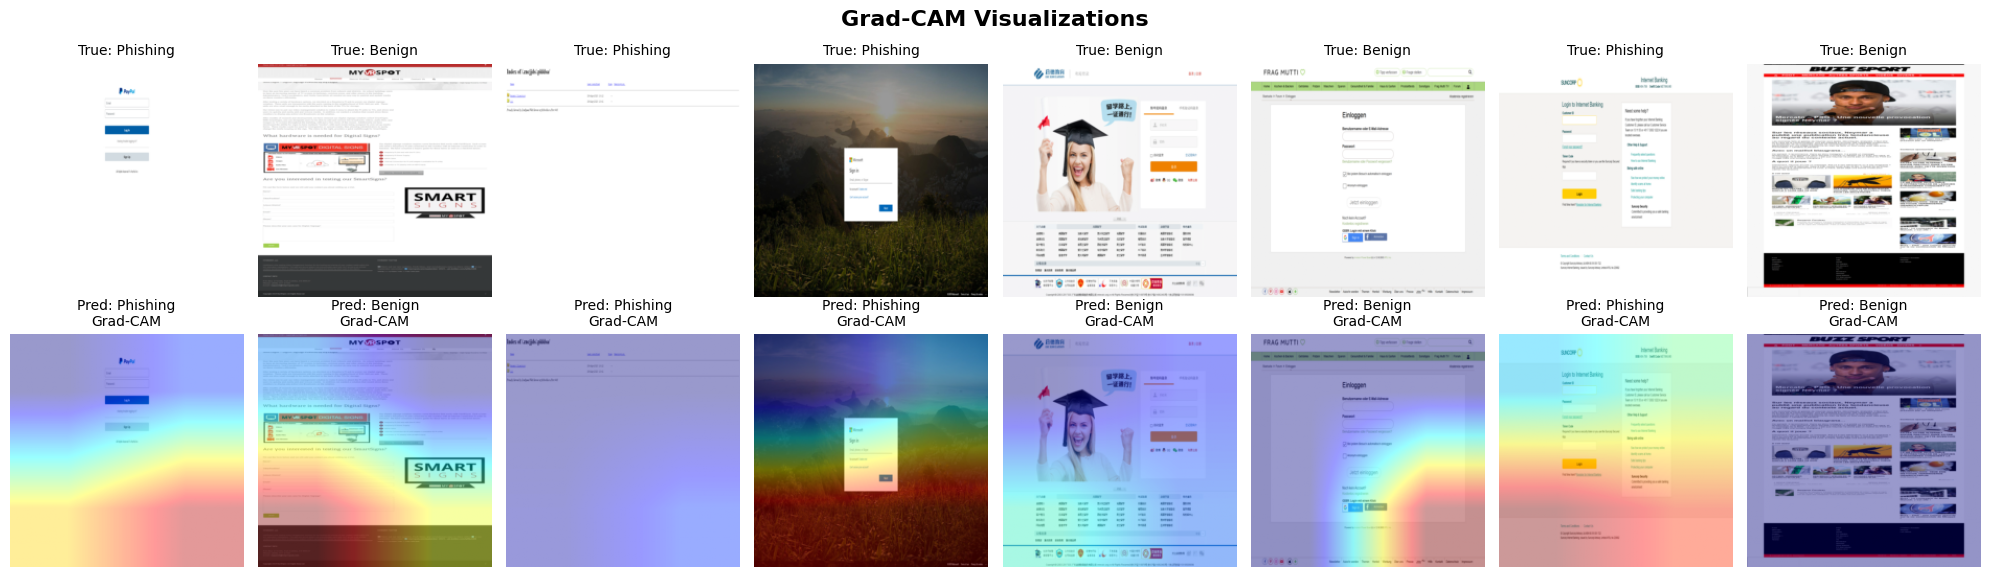

 Generated Grad-CAM for 8 samples


In [43]:
# Grad-CAM Setup and Generation
print("EXPLAINABILITY - GRAD-CAM")

try:
    target_layer = model.visual_branch.backbone.features[-1]
    visual_explainer = GradCAMExplainer(model, target_layer)
    print(" Grad-CAM explainer initialized")

    num_samples = min(8, len(test_loader.dataset))
    sample_images_list = []
    sample_heatmaps = []
    sample_labels_list = []
    sample_predictions_list = []

    model.eval()
    count = 0
    for batch in test_loader:
        if count >= num_samples:
            break
        images = batch['image'].to(device, non_blocking=True)
        text_input_ids = batch['text_input_ids'].to(device, non_blocking=True)
        text_attention_mask = batch['text_attention_mask'].to(device, non_blocking=True)
        labels = batch['label']

        for i in range(min(images.size(0), num_samples - count)):
            single_image = images[i:i+1].clone().detach().requires_grad_(True)
            single_text_ids = text_input_ids[i:i+1].to(device, non_blocking=True)
            single_text_mask = text_attention_mask[i:i+1].to(device, non_blocking=True)
            single_label = labels[i].item()

            try:
                # Generate heatmap with text inputs
                heatmap = visual_explainer.generate_heatmap(
                    single_image,
                    input_ids=single_text_ids,
                    attention_mask=single_text_mask
                )

                # Get prediction
                with torch.no_grad():
                    outputs = model(single_image.detach(), single_text_ids, single_text_mask)
                    pred = torch.argmax(outputs, dim=1).item()

                # Denormalize image for visualization
                mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
                img_denorm = (single_image.detach() * std + mean).squeeze(0).cpu()

                # Ensure heatmap is 2D for visualization
                if len(heatmap.shape) > 2:
                    heatmap = np.mean(heatmap, axis=0) if heatmap.shape[0] > 1 else heatmap[0]
                elif len(heatmap.shape) == 1:
                    # If 1D, reshape to approximate square
                    side_len = int(np.sqrt(len(heatmap)))
                    heatmap = heatmap[:side_len*side_len].reshape(side_len, side_len)

                sample_images_list.append(img_denorm.permute(1, 2, 0).numpy())
                sample_heatmaps.append(heatmap)
                sample_labels_list.append(single_label)
                sample_predictions_list.append(pred)
                count += 1
            except Exception as e:
                print(f"  Warning: Sample {count} failed - {e}")
                continue

    # Only visualize if we have samples
    if len(sample_images_list) == 0:
        print("  No samples successfully processed for Grad-CAM visualization")
    else:
        # Visualize Grad-CAM
        fig, axes = plt.subplots(2, len(sample_images_list), figsize=(20, 6))
        if len(sample_images_list) == 1:
            axes = axes.reshape(2, 1)

        for i in range(len(sample_images_list)):
            img = sample_images_list[i]
            heatmap = sample_heatmaps[i]

            # Resize heatmap to match image dimensions
            if img.shape[0] > 0 and img.shape[1] > 0:
                heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
                heatmap_uint8 = np.uint8(255 * heatmap_resized)
                heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
                heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
                overlayed = cv2.addWeighted((img * 255).astype(np.uint8), 0.6, heatmap_colored, 0.4, 0) / 255.0

                axes[0, i].imshow(np.clip(img, 0, 1))
                label = "Phishing" if sample_labels_list[i] == 1 else "Benign"
                axes[0, i].set_title(f"True: {label}", fontsize=10)
                axes[0, i].axis('off')

                axes[1, i].imshow(np.clip(overlayed, 0, 1))
                pred = "Phishing" if sample_predictions_list[i] == 1 else "Benign"
                axes[1, i].set_title(f"Pred: {pred}\nGrad-CAM", fontsize=10)
                axes[1, i].axis('off')

        plt.suptitle('Grad-CAM Visualizations', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f" Generated Grad-CAM for {len(sample_heatmaps)} samples")

except Exception as e:
    print(f" Grad-CAM setup failed: {e}")


PHASE 6.5: EXPLAINABILITY - SHAP TEXT EXPLANATIONS

 Tokenizer loaded
 SHAP explainer initialized (using gradient-based approach)

 Generating SHAP explanations for 5 samples...


SHAP explanations: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


✅ Generated 5 SHAP explanations



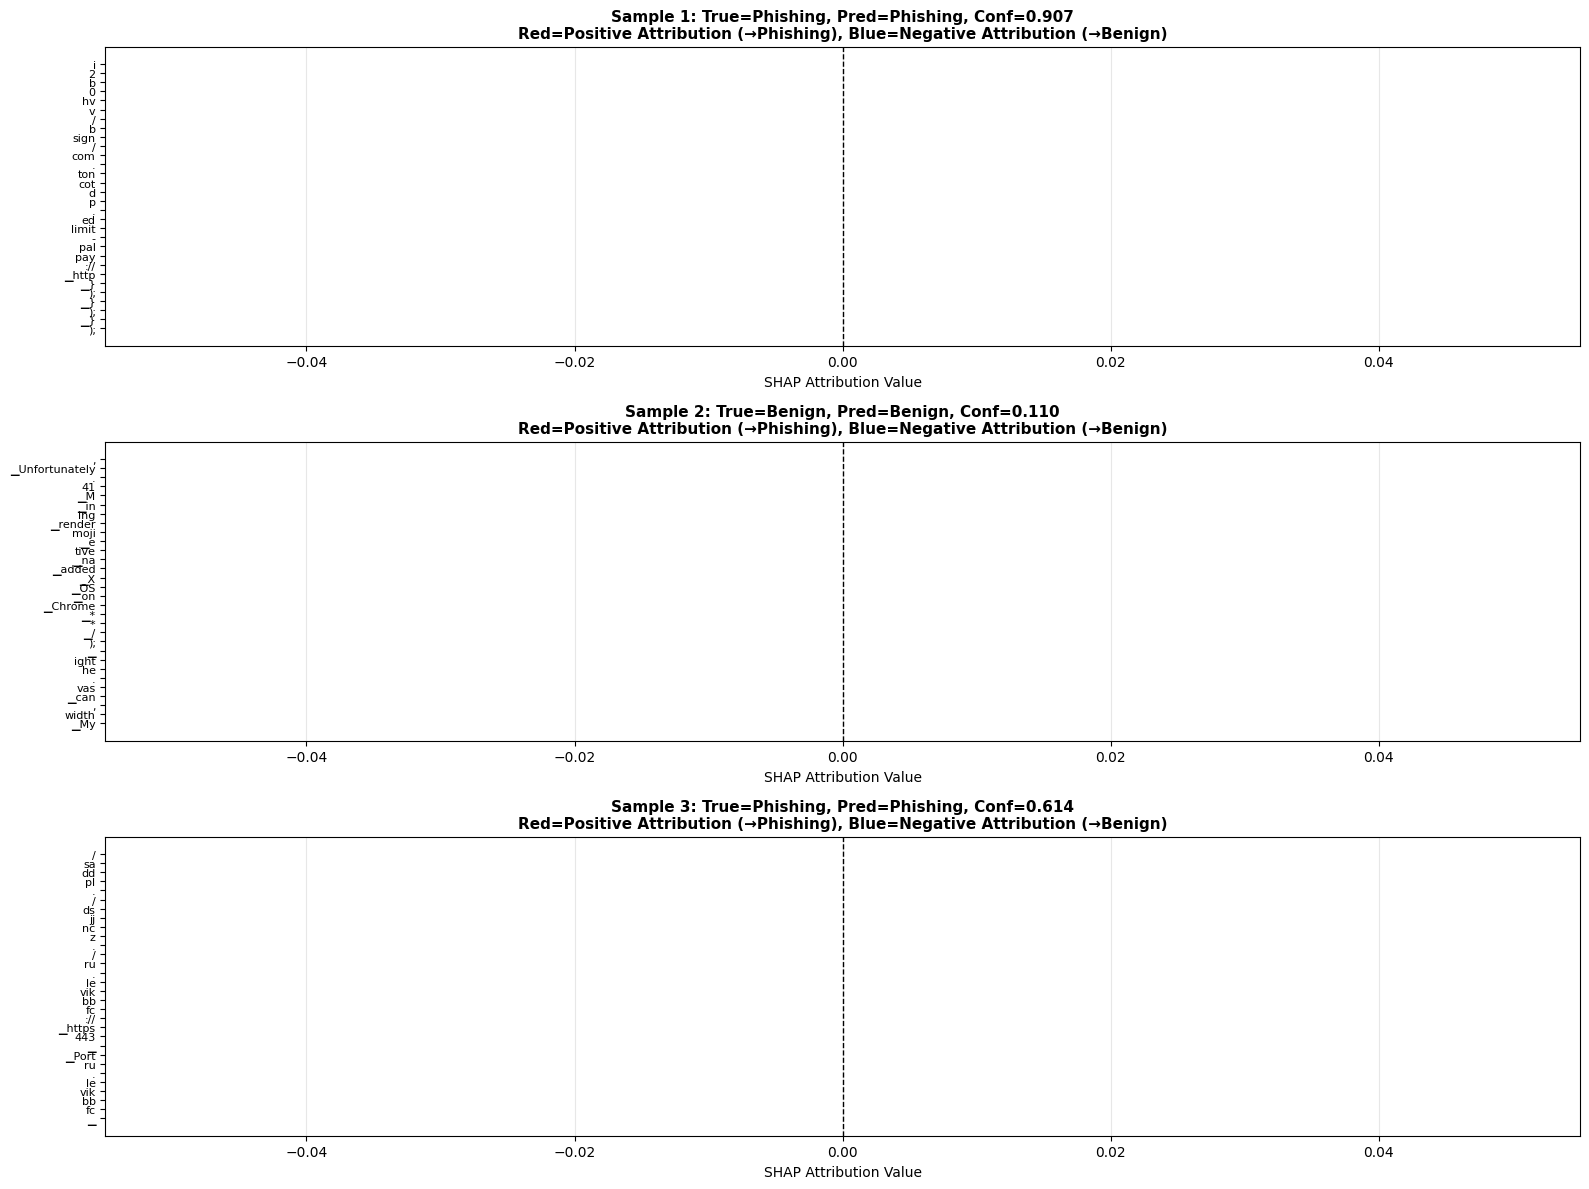


 SHAP Explanation Summary:
--------------------------------------------------------------------------------

Sample 1:
  Text length: 605 chars, 252 tokens
  True label: Phishing
  Predicted: Phishing
  Confidence: 0.907
  Avg |attribution|: 0.0000
  Most important token: '▁Log' (attribution: 0.0000)
  Top 5 important tokens: [('i', 0.0), ('2', 0.0), ('b', 0.0), ('0', 0.0), ('hv', 0.0)]

Sample 2:
  Text length: 1369 chars, 510 tokens
  True label: Benign
  Predicted: Benign
  Confidence: 0.890
  Avg |attribution|: 0.0000
  Most important token: '▁My' (attribution: 0.0000)
  Top 5 important tokens: [('▁My', 0.0), (',', 0.0), ('▁Unfortunately', 0.0), ('.', 0.0), ('41', 0.0)]

Sample 3:
  Text length: 255 chars, 91 tokens
  True label: Phishing
  Predicted: Phishing
  Confidence: 0.614
  Avg |attribution|: 0.0000
  Most important token: '▁Index' (attribution: 0.0000)
  Top 5 important tokens: [('/', 0.0), ('sa', 0.0), ('dd', 0.0), ('pl', 0.0), ('.', 0.0)]

Sample 4:
  Text length: 499 c

In [44]:
# Cell 25.5: SHAP Text Explanations
print("\n" + "="*80)
print("PHASE 6.5: EXPLAINABILITY - SHAP TEXT EXPLANATIONS")
print("="*80 + "\n")

try:
    # Get tokenizer from model's text branch
    if hasattr(model.text_branch, 'tokenizer'):
        tokenizer = model.text_branch.tokenizer
    else:
        from transformers import AutoTokenizer
        tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

    print(" Tokenizer loaded")

    # Initialize SHAP explainer
    shap_explainer = TextExplainerFactory.create_explainer(
        method="shap",
        model=model,
        tokenizer=tokenizer,
        max_length=512,
        device=str(device)
    )

    if shap_explainer is None:
        print("  SHAP not available - skipping text explanations")
    else:
        print(" SHAP explainer initialized (using gradient-based approach)")

        # Collect some samples for explanation (prefer misclassified for analysis)
        num_shap_samples = min(5, len(test_loader.dataset))
        sample_texts = []
        sample_labels_list = []
        sample_predictions_list = []
        sample_probs_list = []
        sample_indices = []

        model.eval()
        count = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                if count >= num_shap_samples:
                    break

                images = batch['image'].to(device, non_blocking=True)
                text_input_ids = batch['text_input_ids'].to(device, non_blocking=True)
                text_attention_mask = batch['text_attention_mask'].to(device, non_blocking=True)
                labels = batch['label']

                # Get predictions
                if use_amp_inference:
                    with autocast_context:
                        outputs = model(images, text_input_ids, text_attention_mask)
                else:
                    outputs = model(images, text_input_ids, text_attention_mask)

                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                # Decode text from input_ids for SHAP
                for i in range(min(len(labels), num_shap_samples - count)):
                    # Decode text (remove special tokens)
                    decoded_text = tokenizer.decode(
                        text_input_ids[i].cpu(),
                        skip_special_tokens=True
                    )

                    # Only use if text is not empty and not too long
                    if len(decoded_text.strip()) > 10 and len(decoded_text) < 2000:
                        sample_texts.append(decoded_text)
                        sample_labels_list.append(labels[i].item())
                        sample_predictions_list.append(preds[i].item())
                        sample_probs_list.append(probs[i].cpu().numpy())
                        sample_indices.append(count)
                        count += 1

                    if count >= num_shap_samples:
                        break

        if len(sample_texts) == 0:
            print("  No suitable text samples found for SHAP explanation")
        else:
            print(f"\n Generating SHAP explanations for {len(sample_texts)} samples...")

            # Generate SHAP explanations
            shap_results = []
            for i, text in enumerate(tqdm(sample_texts, desc="SHAP explanations")):
                try:
                    explanation = shap_explainer.explain_text(text, num_samples=100)
                    shap_results.append({
                        'text': text,
                        'attributions': explanation['attributions'],
                        'tokens': explanation['tokens'],
                        'true_label': sample_labels_list[i],
                        'predicted_label': sample_predictions_list[i],
                        'probabilities': sample_probs_list[i]
                    })
                except Exception as e:
                    print(f"  Warning: SHAP explanation failed for sample {i}: {e}")
                    continue

            if len(shap_results) == 0:
                print("⚠️  No SHAP explanations generated successfully")
            else:
                print(f"✅ Generated {len(shap_results)} SHAP explanations\n")

                # Visualize SHAP explanations
                num_viz = min(3, len(shap_results))
                fig, axes = plt.subplots(num_viz, 1, figsize=(16, 4*num_viz))
                if num_viz == 1:
                    axes = [axes]

                for idx, result in enumerate(shap_results[:num_viz]):
                    ax = axes[idx]

                    # Get attribution values (ensure they're numeric)
                    attributions = result['attributions']
                    tokens = result['tokens']

                    # Convert to numpy if needed and flatten
                    if isinstance(attributions, (list, np.ndarray)):
                        attr_values = np.array(attributions).flatten()
                    else:
                        attr_values = np.array([float(x) for x in attributions]).flatten()

                    # Ensure same length
                    min_len = min(len(attr_values), len(tokens))
                    attr_values = attr_values[:min_len]
                    tokens_display = tokens[:min_len]

                    # Create color mapping: positive = red (phishing), negative = blue (benign)
                    colors = ['red' if x > 0 else 'blue' for x in attr_values]

                    # Plot horizontal bar chart
                    y_pos = np.arange(len(tokens_display))
                    bars = ax.barh(y_pos, attr_values, color=colors, alpha=0.6)

                    # Limit tokens displayed (show top important ones)
                    if len(tokens_display) > 30:
                        # Show top 30 most important tokens
                        top_indices = np.argsort(np.abs(attr_values))[-30:]
                        top_indices = sorted(top_indices)
                        tokens_display = [tokens_display[i] for i in top_indices]
                        attr_values = attr_values[top_indices]
                        colors = [colors[i] for i in top_indices]
                        y_pos = np.arange(len(tokens_display))
                        ax.clear()
                        ax.barh(y_pos, attr_values, color=colors, alpha=0.6)

                    ax.set_yticks(y_pos)
                    ax.set_yticklabels(tokens_display, fontsize=8)
                    ax.set_xlabel('SHAP Attribution Value', fontsize=10)

                    true_label_str = "Phishing" if result['true_label'] == 1 else "Benign"
                    pred_label_str = "Phishing" if result['predicted_label'] == 1 else "Benign"
                    prob_phishing = result['probabilities'][1]

                    ax.set_title(
                        f'Sample {idx+1}: True={true_label_str}, Pred={pred_label_str}, '
                        f'Conf={prob_phishing:.3f}\n'
                        f'Red=Positive Attribution (→Phishing), Blue=Negative Attribution (→Benign)',
                        fontsize=11, fontweight='bold'
                    )
                    ax.grid(axis='x', alpha=0.3)
                    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

                plt.tight_layout()
                plt.show()

                # Print summary statistics
                print("\n SHAP Explanation Summary:")
                print("-" * 80)
                for idx, result in enumerate(shap_results):
                    avg_attr = np.mean(np.abs(result['attributions']))
                    max_attr_idx = np.argmax(np.abs(result['attributions']))
                    max_attr_token = result['tokens'][max_attr_idx] if max_attr_idx < len(result['tokens']) else "N/A"

                    print(f"\nSample {idx+1}:")
                    print(f"  Text length: {len(result['text'])} chars, {len(result['tokens'])} tokens")
                    print(f"  True label: {'Phishing' if result['true_label'] == 1 else 'Benign'}")
                    print(f"  Predicted: {'Phishing' if result['predicted_label'] == 1 else 'Benign'}")
                    print(f"  Confidence: {result['probabilities'][result['predicted_label']]:.3f}")
                    print(f"  Avg |attribution|: {avg_attr:.4f}")
                    print(f"  Most important token: '{max_attr_token}' (attribution: {result['attributions'][max_attr_idx]:.4f})")

                    # Show top 5 most important tokens
                    top_indices = np.argsort(np.abs(result['attributions']))[-5:]
                    top_tokens = [(result['tokens'][i], result['attributions'][i])
                                 for i in reversed(top_indices) if i < len(result['tokens'])]
                    print(f"  Top 5 important tokens: {top_tokens}")

except Exception as e:
    print(f"  SHAP text explanations failed: {e}")
    import traceback
    traceback.print_exc()

ERROR ANALYSIS
Error Analysis:
  Total samples: 100
  Correct: 94
  Misclassified: 6
  Error rate: 0.0600
  False Positives: 2
  False Negatives: 4


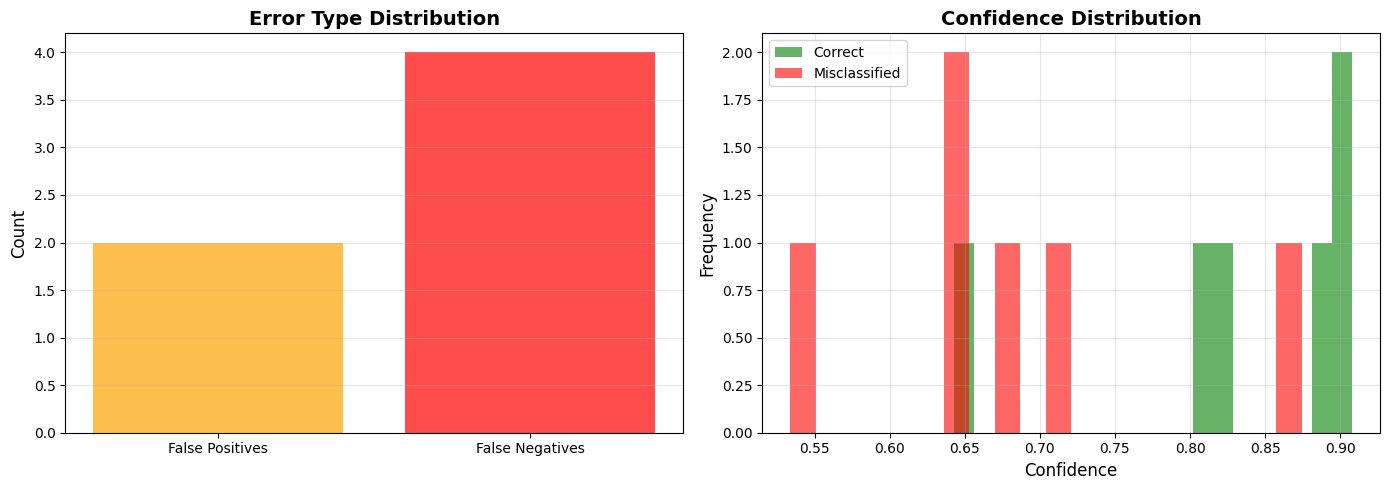

In [45]:
# Error Analysis
print("ERROR ANALYSIS")

misclassified = []
correctly_classified = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        text_input_ids = batch['text_input_ids'].to(device)
        text_attention_mask = batch['text_attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images, text_input_ids, text_attention_mask)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = preds[i].item()
            prob = probs[i, pred].item()

            if label != pred:
                misclassified.append({'true': label, 'pred': pred, 'conf': prob})
            else:
                correctly_classified.append({'true': label, 'pred': pred, 'conf': prob})

false_positives = sum(1 for m in misclassified if m['true'] == 0 and m['pred'] == 1)
false_negatives = sum(1 for m in misclassified if m['true'] == 1 and m['pred'] == 0)

total = len(misclassified) + len(correctly_classified)
error_rate = len(misclassified) / total if total > 0 else 0

print(f"Error Analysis:")
print(f"  Total samples: {total:,}")
print(f"  Correct: {len(correctly_classified):,}")
print(f"  Misclassified: {len(misclassified):,}")
print(f"  Error rate: {error_rate:.4f}")
print(f"  False Positives: {false_positives}")
print(f"  False Negatives: {false_negatives}")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['False Positives', 'False Negatives'], [false_positives, false_negatives],
            color=['orange', 'red'], alpha=0.7)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Error Type Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

if misclassified:
    misclass_conf = [m['conf'] for m in misclassified]
    correct_conf = [c['conf'] for c in correctly_classified[:len(misclassified)]]

    axes[1].hist(correct_conf, bins=20, alpha=0.6, label='Correct', color='green')
    axes[1].hist(misclass_conf, bins=20, alpha=0.6, label='Misclassified', color='red')
    axes[1].set_xlabel('Confidence', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


ADVERSARIAL TESTING

Adversarial Robustness Results:
Epsilon    Original Acc    Adversarial Acc    Robustness  
------------------------------------------------------------
0.010      0.9400          0.5200             0.5532      
0.030      0.9400          0.5200             0.5532      
0.050      0.9400          0.5100             0.5426      
0.100      0.9400          0.5100             0.5426      


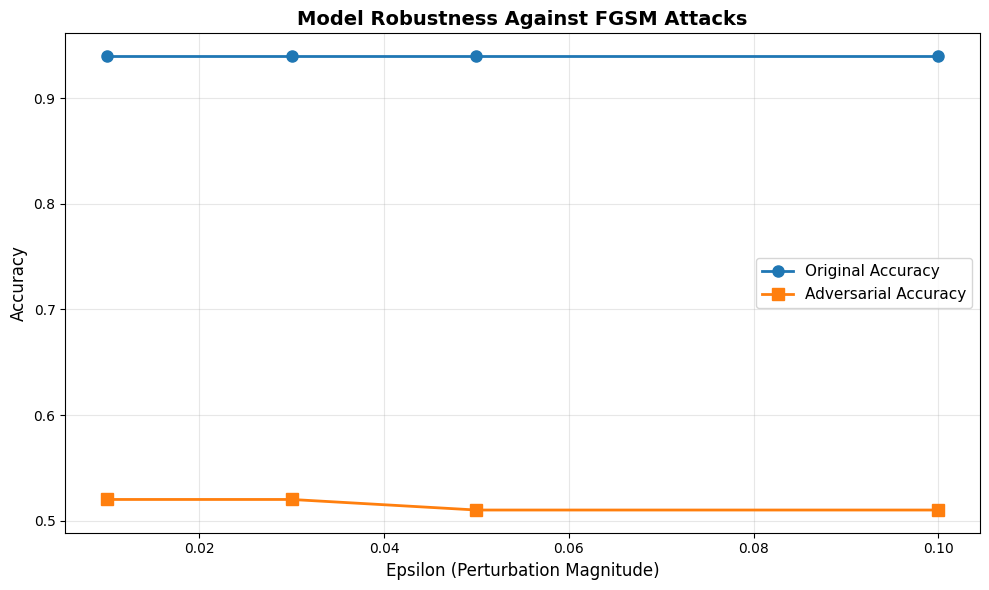

In [46]:
# Adversarial Testing
print("ADVERSARIAL TESTING")

adversarial_tester = AdversarialTester(model, device=str(device))

num_adversarial_samples = min(100, len(test_loader.dataset))
test_images = []
test_input_ids = []
test_attention_mask = []
test_labels = []

count = 0
with torch.no_grad():
    for batch in test_loader:
        if count >= num_adversarial_samples:
            break
        for i in range(min(batch['image'].size(0), num_adversarial_samples - count)):
            test_images.append(batch['image'][i:i+1].to(device))
            test_input_ids.append(batch['text_input_ids'][i:i+1].to(device))
            test_attention_mask.append(batch['text_attention_mask'][i:i+1].to(device))
            test_labels.append(batch['label'][i:i+1].to(device))
            count += 1

epsilon_values = [0.01, 0.03, 0.05, 0.1]
robustness_results = {}

for epsilon in epsilon_values:
    correct_original = 0
    correct_adversarial = 0

    model.eval()
    for i in range(len(test_images)):
        with torch.no_grad():
            orig_output = model(test_images[i], test_input_ids[i], test_attention_mask[i])
            orig_pred = torch.argmax(orig_output, dim=1).item()

        if orig_pred == test_labels[i].item():
            correct_original += 1

        try:
            adv_image, _ = adversarial_tester.fgsm_attack(
                test_images[i], test_input_ids[i], test_attention_mask[i],
                test_labels[i], epsilon=epsilon, target_modality="visual"
            )

            with torch.no_grad():
                adv_output = model(adv_image, test_input_ids[i], test_attention_mask[i])
                adv_pred = torch.argmax(adv_output, dim=1).item()

            if adv_pred == test_labels[i].item():
                correct_adversarial += 1
        except:
            pass

    orig_acc = correct_original / len(test_images)
    adv_acc = correct_adversarial / len(test_images)
    robustness = adv_acc / orig_acc if orig_acc > 0 else 0

    robustness_results[epsilon] = {
        'original_accuracy': orig_acc,
        'adversarial_accuracy': adv_acc,
        'robustness_ratio': robustness
    }

print("\nAdversarial Robustness Results:")
print(f"{'Epsilon':<10} {'Original Acc':<15} {'Adversarial Acc':<18} {'Robustness':<12}")
print("-" * 60)
for eps, results in robustness_results.items():
    print(f"{eps:<10.3f} {results['original_accuracy']:<15.4f} "
          f"{results['adversarial_accuracy']:<18.4f} {results['robustness_ratio']:<12.4f}")

# Visualize robustness
epsilons = list(robustness_results.keys())
orig_accs = [robustness_results[eps]['original_accuracy'] for eps in epsilons]
adv_accs = [robustness_results[eps]['adversarial_accuracy'] for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.plot(epsilons, orig_accs, 'o-', label='Original Accuracy', linewidth=2, markersize=8)
plt.plot(epsilons, adv_accs, 's-', label='Adversarial Accuracy', linewidth=2, markersize=8)
plt.xlabel('Epsilon (Perturbation Magnitude)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Robustness Against FGSM Attacks', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


PERFORMANCE METRICS
Measuring inference time...


Inference timing: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Performance Metrics:
  Average inference time: 0.00 ± 0.00 ms
  Model size: 1085.80 MB
  Inference target: Met (<300ms)
  Size target: Not met (<150MB)


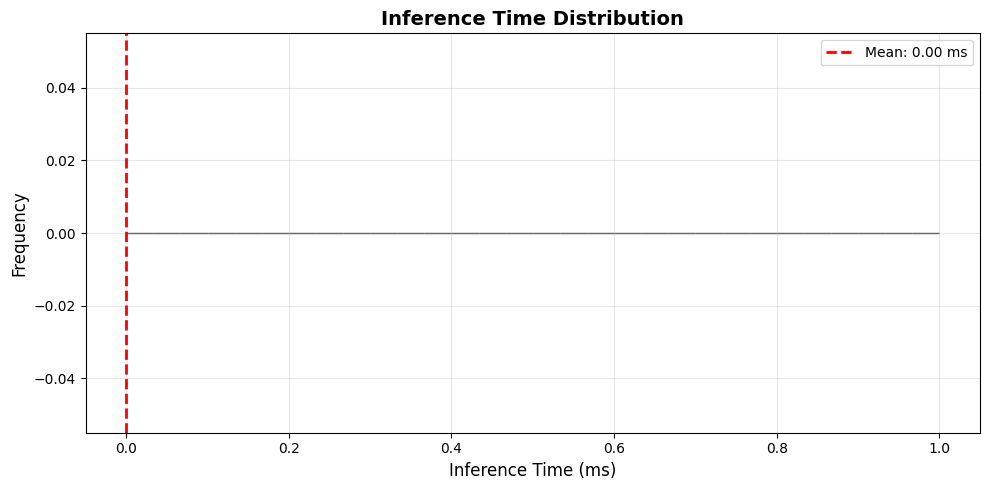

In [47]:
# Performance Metrics
print("PERFORMANCE METRICS")

model.eval()
inference_times = []

print("Measuring inference time...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference timing"):
        images = batch['image'].to(device)
        text_input_ids = batch['text_input_ids'].to(device)
        text_attention_mask = batch['text_attention_mask'].to(device)

        if len(inference_times) == 0:
            _ = model(images, text_input_ids, text_attention_mask)
            continue

        start_time = time.time()
        _ = model(images, text_input_ids, text_attention_mask)
        batch_time = (time.time() - start_time) * 1000
        batch_size = images.size(0)
        inference_times.extend([batch_time / batch_size] * batch_size)

avg_inference_time = np.mean(inference_times) if inference_times else 0
std_inference_time = np.std(inference_times) if inference_times else 0

print(f"\nPerformance Metrics:")
print(f"  Average inference time: {avg_inference_time:.2f} ± {std_inference_time:.2f} ms")
print(f"  Model size: {model_size_mb:.2f} MB")
print(f"  Inference target: {'Met' if avg_inference_time < 300 else 'Not met'} (<300ms)")
print(f"  Size target: {'Met' if model_size_mb < 150 else 'Not met'} (<150MB)")

plt.figure(figsize=(10, 5))
plt.hist(inference_times, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(avg_inference_time, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {avg_inference_time:.2f} ms')
plt.xlabel('Inference Time (ms)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Inference Time Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [48]:
#  Final Summary Report
print("FINAL SUMMARY REPORT")

summary = {
    'Dataset': {
        'Total samples': f"{NUM_SAMPLES:,}",
        'Training samples': f"{len(train_loader.dataset):,}",
        'Test samples': f"{len(test_loader.dataset):,}",
        'Class balance': f"{dataset_stats['balance_ratio']:.4f}"
    },
    'Model': {
        'Architecture': 'MobileNetV2 + XLM-RoBERTa',
        'Total parameters': f"{total_params:,}",
        'Model size': f"{model_size_mb:.2f} MB"
    },
    'Training': {
        'Epochs': NUM_EPOCHS,
        'Training time': f"{training_time/60:.2f} minutes",
        'Final train loss': f"{train_history['train_losses'][-1]:.4f}",
        'Final val loss': f"{train_history['val_losses'][-1]:.4f}"
    },
    'Performance': {
        'Accuracy': f"{eval_results['accuracy']:.4f}",
        'F1 Score': f"{eval_results['f1_weighted']:.4f}",
        'ROC-AUC': f"{eval_results.get('roc_auc', 'N/A')}",
        'MCC': f"{eval_results['mcc']:.4f}",
        'Inference time': f"{avg_inference_time:.2f} ms"
    },
    'Error Analysis': {
        'Error rate': f"{error_rate:.4f}",
        'False positives': false_positives,
        'False negatives': false_negatives
    }
}

for section, metrics in summary.items():
    print(f"\n{section}:")
    print("-" * 80)
    for key, value in metrics.items():
        print(f"  {key:<25}: {value}")



FINAL SUMMARY REPORT

Dataset:
--------------------------------------------------------------------------------
  Total samples            : 1,000
  Training samples         : 800
  Test samples             : 100
  Class balance            : 1.0391

Model:
--------------------------------------------------------------------------------
  Architecture             : MobileNetV2 + XLM-RoBERTa
  Total parameters         : 284,637,058
  Model size               : 1085.80 MB

Training:
--------------------------------------------------------------------------------
  Epochs                   : 10
  Training time            : 13.99 minutes
  Final train loss         : 0.0016
  Final val loss           : 0.0148

Performance:
--------------------------------------------------------------------------------
  Accuracy                 : 0.9400
  F1 Score                 : 0.9400
  ROC-AUC                  : 0.9847939175670268
  MCC                      : 0.8808
  Inference time           : 0.00 ms